In [51]:
from collections import Counter
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi

# Preprocessing and Model Selection
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve

from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

from catboost import CatBoostClassifier

In [52]:
preprocessed_path = "../data/preprocessed/"

train_df = pd.read_csv(preprocessed_path + "train.csv")
test_df = pd.read_csv(preprocessed_path + "test.csv")
val_df = pd.read_csv(preprocessed_path + "validate.csv")


target = ["TX_FRAUD"]

y_train = train_df[target].values
y_val = val_df[target].values
y_test = test_df[target].values

X_train = train_df.drop(target, axis=1)
X_val = val_df.drop(target, axis=1)
X_test = test_df.drop(target, axis=1)

In [53]:
import optuna
from sklearn.metrics import recall_score

# Define the pipeline components
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=1)


def objective(trial):
    # Define the hyperparameters to be tuned
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),
        #"random_seed": 42,
        "random_seed": 123
        # "eval_metric": "Recall",
        "eval_metric": "TotalF1",
        "verbose": False,
    }

    # Create the CatBoost classifier with the suggested hyperparameters
    model = CatBoostClassifier(**params)

    # Create the pipeline
    pipeline = imbpipeline(
        [
            ("preprocessor", scaler),
            ("oversampling", over),
            ("undersampling", under),
            ("classifier", model),
        ]
    )

    # Fit the model on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the validation data
    y_pred = pipeline.predict(X_val)

    # Calculate the recall score
    recall = recall_score(y_val, y_pred)

    return recall


# Create an Optuna study
study = optuna.create_study(
    direction="maximize",
    storage="sqlite:///db.sqlite3",
    study_name="quadratic-simple",
    load_if_exists=True,
)

# Optimize the objective function
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Get the best parameters and best recall score
best_params = study.best_params
best_recall = study.best_value

print("Best Parameters:", best_params)
print("Best Recall:", best_recall)

[I 2023-12-19 13:05:48,717] Using an existing study with name 'quadratic-simple' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:05:50,715] Trial 200 finished with value: 0.6987012987012987 and parameters: {'iterations': 207, 'learning_rate': 0.0008786187071034391, 'depth': 6, 'l2_leaf_reg': 4.632448185297568}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:05:52,598] Trial 201 finished with value: 0.7012987012987013 and parameters: {'iterations': 228, 'learning_rate': 0.0008352659172989378, 'depth': 6, 'l2_leaf_reg': 4.605240031987445}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:05:54,421] Trial 202 finished with value: 0.6831168831168831 and parameters: {'iterations': 206, 'learning_rate': 0.0008543735523826822, 'depth': 6, 'l2_leaf_reg': 4.630319776012005}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:05:56,458] Trial 203 finished with value: 0.6883116883116883 and parameters: {'iterations': 229, 'learning_rate': 0.0009882162496135847, 'depth': 6, 'l2_leaf_reg': 3.7928933515678263}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:05:57,448] Trial 204 finished with value: 0.6909090909090909 and parameters: {'iterations': 179, 'learning_rate': 0.0007554840804598635, 'depth': 6, 'l2_leaf_reg': 6.984043663999322}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:05:59,207] Trial 205 finished with value: 0.7012987012987013 and parameters: {'iterations': 203, 'learning_rate': 0.0009195004769929491, 'depth': 6, 'l2_leaf_reg': 2.179063967570467}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:00,100] Trial 206 finished with value: 0.6779220779220779 and parameters: {'iterations': 151, 'learning_rate': 0.000829765177252655, 'depth': 6, 'l2_leaf_reg': 4.129648005274579}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:01,964] Trial 207 finished with value: 0.6909090909090909 and parameters: {'iterations': 219, 'learning_rate': 0.0009034778190767233, 'depth': 6, 'l2_leaf_reg': 4.6537836413661}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:07,027] Trial 208 finished with value: 0.6883116883116883 and parameters: {'iterations': 676, 'learning_rate': 0.0006997083061277509, 'depth': 6, 'l2_leaf_reg': 3.1855957668695045}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:08,114] Trial 209 finished with value: 0.6857142857142857 and parameters: {'iterations': 194, 'learning_rate': 0.0009088399907640794, 'depth': 6, 'l2_leaf_reg': 5.2615027354441475}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:10,600] Trial 210 finished with value: 0.6909090909090909 and parameters: {'iterations': 267, 'learning_rate': 0.0007338605972461004, 'depth': 6, 'l2_leaf_reg': 0.715015772086366}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:12,693] Trial 211 finished with value: 0.6935064935064935 and parameters: {'iterations': 213, 'learning_rate': 0.003140562697622591, 'depth': 6, 'l2_leaf_reg': 2.204137053034319}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:14,755] Trial 212 finished with value: 0.6961038961038961 and parameters: {'iterations': 235, 'learning_rate': 0.0008682232816859187, 'depth': 6, 'l2_leaf_reg': 0.5363377025524292}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:16,836] Trial 213 finished with value: 0.6727272727272727 and parameters: {'iterations': 231, 'learning_rate': 0.0008067991705172536, 'depth': 6, 'l2_leaf_reg': 0.4821181726176691}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:18,953] Trial 214 finished with value: 0.6883116883116883 and parameters: {'iterations': 235, 'learning_rate': 0.0006429656625113835, 'depth': 6, 'l2_leaf_reg': 0.5319441023991175}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:21,349] Trial 215 finished with value: 0.6857142857142857 and parameters: {'iterations': 262, 'learning_rate': 0.0009270874462386837, 'depth': 6, 'l2_leaf_reg': 0.4374943374091235}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:22,369] Trial 216 finished with value: 0.6727272727272727 and parameters: {'iterations': 167, 'learning_rate': 0.0005481810298660139, 'depth': 6, 'l2_leaf_reg': 0.6101804280493793}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:23,507] Trial 217 finished with value: 0.6623376623376623 and parameters: {'iterations': 198, 'learning_rate': 0.0009518313871690412, 'depth': 6, 'l2_leaf_reg': 3.186033595359469}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:25,582] Trial 218 finished with value: 0.6831168831168831 and parameters: {'iterations': 252, 'learning_rate': 0.0008604196897868537, 'depth': 5, 'l2_leaf_reg': 0.5527203639878894}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:28,371] Trial 219 finished with value: 0.6909090909090909 and parameters: {'iterations': 294, 'learning_rate': 0.0010227748884882228, 'depth': 6, 'l2_leaf_reg': 0.38173178324605633}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:30,471] Trial 220 finished with value: 0.6935064935064935 and parameters: {'iterations': 228, 'learning_rate': 0.001024748747625788, 'depth': 6, 'l2_leaf_reg': 1.686436801788448}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:32,474] Trial 221 finished with value: 0.6909090909090909 and parameters: {'iterations': 209, 'learning_rate': 0.0024837341909503758, 'depth': 6, 'l2_leaf_reg': 0.10776588885652977}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:33,618] Trial 222 finished with value: 0.6779220779220779 and parameters: {'iterations': 198, 'learning_rate': 0.0003405560925478969, 'depth': 6, 'l2_leaf_reg': 0.233515420195456}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:35,749] Trial 223 finished with value: 0.6831168831168831 and parameters: {'iterations': 238, 'learning_rate': 0.00010864090113231233, 'depth': 6, 'l2_leaf_reg': 0.6506996106108952}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:37,756] Trial 224 finished with value: 0.6909090909090909 and parameters: {'iterations': 215, 'learning_rate': 0.002698966884004997, 'depth': 6, 'l2_leaf_reg': 0.879719246019908}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:38,816] Trial 225 finished with value: 0.6675324675324675 and parameters: {'iterations': 173, 'learning_rate': 0.004424116875439862, 'depth': 6, 'l2_leaf_reg': 0.2689558952932438}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:39,980] Trial 226 finished with value: 0.6831168831168831 and parameters: {'iterations': 193, 'learning_rate': 0.0010923847420087516, 'depth': 6, 'l2_leaf_reg': 0.3369551289037864}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:42,579] Trial 227 finished with value: 0.6961038961038961 and parameters: {'iterations': 270, 'learning_rate': 0.0021897741864289754, 'depth': 6, 'l2_leaf_reg': 0.7810993667558479}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:45,109] Trial 228 finished with value: 0.6857142857142857 and parameters: {'iterations': 276, 'learning_rate': 0.002141465252450856, 'depth': 6, 'l2_leaf_reg': 0.5238761367690661}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:47,850] Trial 229 finished with value: 0.6805194805194805 and parameters: {'iterations': 303, 'learning_rate': 0.0030355166045699616, 'depth': 6, 'l2_leaf_reg': 0.7681803680714822}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:50,222] Trial 230 finished with value: 0.6935064935064935 and parameters: {'iterations': 256, 'learning_rate': 0.0023912007474254974, 'depth': 6, 'l2_leaf_reg': 0.5879022270063352}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:52,390] Trial 231 finished with value: 0.6987012987012987 and parameters: {'iterations': 231, 'learning_rate': 0.0022557726132791346, 'depth': 6, 'l2_leaf_reg': 5.522749288246714}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:54,632] Trial 232 finished with value: 0.6987012987012987 and parameters: {'iterations': 239, 'learning_rate': 0.002420843201618682, 'depth': 6, 'l2_leaf_reg': 5.22603132181293}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:56,935] Trial 233 finished with value: 0.6753246753246753 and parameters: {'iterations': 243, 'learning_rate': 0.0035183294794481636, 'depth': 6, 'l2_leaf_reg': 5.746014136072656}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:06:59,531] Trial 234 finished with value: 0.6805194805194805 and parameters: {'iterations': 265, 'learning_rate': 0.0026780718511548915, 'depth': 6, 'l2_leaf_reg': 5.243874726857667}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:01,745] Trial 235 finished with value: 0.6233766233766234 and parameters: {'iterations': 239, 'learning_rate': 0.054696712360912426, 'depth': 6, 'l2_leaf_reg': 6.481504990657131}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:05,218] Trial 236 finished with value: 0.6701298701298701 and parameters: {'iterations': 411, 'learning_rate': 0.002227018285484483, 'depth': 6, 'l2_leaf_reg': 4.443141305209356}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:08,204] Trial 237 finished with value: 0.6831168831168831 and parameters: {'iterations': 283, 'learning_rate': 0.002909302710652799, 'depth': 7, 'l2_leaf_reg': 8.032161677555866}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:10,380] Trial 238 finished with value: 0.6935064935064935 and parameters: {'iterations': 226, 'learning_rate': 0.0024293912201718616, 'depth': 6, 'l2_leaf_reg': 5.804056485997227}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:13,143] Trial 239 finished with value: 0.6987012987012987 and parameters: {'iterations': 263, 'learning_rate': 0.0011156798423999001, 'depth': 7, 'l2_leaf_reg': 5.138905918202546}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:17,875] Trial 240 finished with value: 0.6883116883116883 and parameters: {'iterations': 437, 'learning_rate': 0.0009138786725135164, 'depth': 7, 'l2_leaf_reg': 4.943195609361569}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:20,775] Trial 241 finished with value: 0.6883116883116883 and parameters: {'iterations': 256, 'learning_rate': 0.0011435566492739428, 'depth': 7, 'l2_leaf_reg': 9.87384734428736}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:23,821] Trial 242 finished with value: 0.6935064935064935 and parameters: {'iterations': 272, 'learning_rate': 0.0019272298245490973, 'depth': 7, 'l2_leaf_reg': 5.145067562965598}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:26,748] Trial 243 finished with value: 0.6935064935064935 and parameters: {'iterations': 248, 'learning_rate': 0.0010864155438789446, 'depth': 7, 'l2_leaf_reg': 4.2973305940310995}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:30,437] Trial 244 finished with value: 0.6883116883116883 and parameters: {'iterations': 318, 'learning_rate': 0.0012790235977998383, 'depth': 7, 'l2_leaf_reg': 4.806566317124431}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:32,912] Trial 245 finished with value: 0.6831168831168831 and parameters: {'iterations': 218, 'learning_rate': 0.0009613581872941049, 'depth': 6, 'l2_leaf_reg': 5.69616984536039}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:35,906] Trial 246 finished with value: 0.6883116883116883 and parameters: {'iterations': 239, 'learning_rate': 0.0018442845452709348, 'depth': 7, 'l2_leaf_reg': 5.486354557389008}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:39,082] Trial 247 finished with value: 0.6753246753246753 and parameters: {'iterations': 292, 'learning_rate': 0.0008018982836087304, 'depth': 6, 'l2_leaf_reg': 0.6726846860275829}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:41,886] Trial 248 finished with value: 0.6883116883116883 and parameters: {'iterations': 213, 'learning_rate': 0.001185127774700993, 'depth': 7, 'l2_leaf_reg': 5.017509712230428}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:44,791] Trial 249 finished with value: 0.6883116883116883 and parameters: {'iterations': 263, 'learning_rate': 0.0021102013924247597, 'depth': 6, 'l2_leaf_reg': 4.494703734441737}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:47,966] Trial 250 finished with value: 0.6805194805194805 and parameters: {'iterations': 230, 'learning_rate': 0.0035565427235347185, 'depth': 7, 'l2_leaf_reg': 4.105708535008882}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:50,778] Trial 251 finished with value: 0.6909090909090909 and parameters: {'iterations': 250, 'learning_rate': 0.0017450744224723539, 'depth': 6, 'l2_leaf_reg': 6.230757909409772}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:53,528] Trial 252 finished with value: 0.6857142857142857 and parameters: {'iterations': 207, 'learning_rate': 0.002359277038316353, 'depth': 7, 'l2_leaf_reg': 4.931961386688267}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:56,582] Trial 253 finished with value: 0.7038961038961039 and parameters: {'iterations': 275, 'learning_rate': 0.0010203975216749287, 'depth': 6, 'l2_leaf_reg': 0.7788873751336318}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:07:59,833] Trial 254 finished with value: 0.6883116883116883 and parameters: {'iterations': 277, 'learning_rate': 0.0009090920993174707, 'depth': 6, 'l2_leaf_reg': 0.7629798155063248}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:03,458] Trial 255 finished with value: 0.6805194805194805 and parameters: {'iterations': 303, 'learning_rate': 0.0009659228159774472, 'depth': 6, 'l2_leaf_reg': 0.6396237055194696}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:04,975] Trial 256 finished with value: 0.6805194805194805 and parameters: {'iterations': 190, 'learning_rate': 0.004005874703069606, 'depth': 6, 'l2_leaf_reg': 0.5775027165727312}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:07,695] Trial 257 finished with value: 0.6961038961038961 and parameters: {'iterations': 228, 'learning_rate': 0.0011599626626738488, 'depth': 6, 'l2_leaf_reg': 0.6827966101606046}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:11,047] Trial 258 finished with value: 0.6987012987012987 and parameters: {'iterations': 272, 'learning_rate': 0.0010742885472087515, 'depth': 6, 'l2_leaf_reg': 0.8035159993396533}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:14,517] Trial 259 finished with value: 0.6987012987012987 and parameters: {'iterations': 286, 'learning_rate': 0.001085655034151487, 'depth': 6, 'l2_leaf_reg': 0.7233194467062087}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:18,070] Trial 260 finished with value: 0.6987012987012987 and parameters: {'iterations': 293, 'learning_rate': 0.0011003058599487804, 'depth': 6, 'l2_leaf_reg': 0.8147626159994932}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:22,263] Trial 261 finished with value: 0.6883116883116883 and parameters: {'iterations': 318, 'learning_rate': 0.0010582700017766557, 'depth': 6, 'l2_leaf_reg': 0.797389019757093}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:25,623] Trial 262 finished with value: 0.6883116883116883 and parameters: {'iterations': 288, 'learning_rate': 0.0008194105965872405, 'depth': 6, 'l2_leaf_reg': 0.7048997860337476}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:29,209] Trial 263 finished with value: 0.6909090909090909 and parameters: {'iterations': 294, 'learning_rate': 0.0011163917837373669, 'depth': 6, 'l2_leaf_reg': 0.841680729450577}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:32,332] Trial 264 finished with value: 0.6987012987012987 and parameters: {'iterations': 274, 'learning_rate': 0.001008192301777198, 'depth': 6, 'l2_leaf_reg': 0.7121927563784322}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:36,281] Trial 265 finished with value: 0.6961038961038961 and parameters: {'iterations': 339, 'learning_rate': 0.000954448781743939, 'depth': 6, 'l2_leaf_reg': 0.8725898088528258}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:39,438] Trial 266 finished with value: 0.6909090909090909 and parameters: {'iterations': 270, 'learning_rate': 0.0008005174086128865, 'depth': 6, 'l2_leaf_reg': 0.7880991368264461}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:42,910] Trial 267 finished with value: 0.6961038961038961 and parameters: {'iterations': 300, 'learning_rate': 0.0006714859627404283, 'depth': 6, 'l2_leaf_reg': 0.7466850553754854}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:46,050] Trial 268 finished with value: 0.6857142857142857 and parameters: {'iterations': 277, 'learning_rate': 0.0010022298701782143, 'depth': 6, 'l2_leaf_reg': 0.9006113007767177}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:49,392] Trial 269 finished with value: 0.7012987012987013 and parameters: {'iterations': 305, 'learning_rate': 0.0008620456422725682, 'depth': 6, 'l2_leaf_reg': 1.0322176730877268}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:52,967] Trial 270 finished with value: 0.6987012987012987 and parameters: {'iterations': 313, 'learning_rate': 0.0007748116793944699, 'depth': 6, 'l2_leaf_reg': 0.9535724829361889}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:08:56,455] Trial 271 finished with value: 0.6961038961038961 and parameters: {'iterations': 307, 'learning_rate': 0.00075430766125125, 'depth': 6, 'l2_leaf_reg': 1.0228898550407763}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:00,098] Trial 272 finished with value: 0.6831168831168831 and parameters: {'iterations': 328, 'learning_rate': 0.0012606222771243132, 'depth': 6, 'l2_leaf_reg': 0.9551443583462086}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:03,595] Trial 273 finished with value: 0.7038961038961039 and parameters: {'iterations': 307, 'learning_rate': 0.0006590333781327306, 'depth': 6, 'l2_leaf_reg': 0.7063210808596697}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:07,624] Trial 274 finished with value: 0.6987012987012987 and parameters: {'iterations': 352, 'learning_rate': 0.0006242572528165244, 'depth': 6, 'l2_leaf_reg': 0.6886441758539169}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:11,227] Trial 275 finished with value: 0.6961038961038961 and parameters: {'iterations': 326, 'learning_rate': 0.0007153686098098527, 'depth': 6, 'l2_leaf_reg': 0.6475153975757034}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:14,958] Trial 276 finished with value: 0.6831168831168831 and parameters: {'iterations': 352, 'learning_rate': 0.000634629804414615, 'depth': 6, 'l2_leaf_reg': 1.0174715405793646}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:18,035] Trial 277 finished with value: 0.6857142857142857 and parameters: {'iterations': 314, 'learning_rate': 0.0005820518933354176, 'depth': 5, 'l2_leaf_reg': 0.7572541002482656}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:21,929] Trial 278 finished with value: 0.6909090909090909 and parameters: {'iterations': 309, 'learning_rate': 0.0007695193651739572, 'depth': 6, 'l2_leaf_reg': 0.7107179463915421}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:26,001] Trial 279 finished with value: 0.6987012987012987 and parameters: {'iterations': 344, 'learning_rate': 0.0005860834438381556, 'depth': 6, 'l2_leaf_reg': 0.8299905801225904}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:29,926] Trial 280 finished with value: 0.6727272727272727 and parameters: {'iterations': 376, 'learning_rate': 0.0005978572969686281, 'depth': 6, 'l2_leaf_reg': 0.8232991041229836}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:33,647] Trial 281 finished with value: 0.7012987012987013 and parameters: {'iterations': 345, 'learning_rate': 0.0006917957586218265, 'depth': 6, 'l2_leaf_reg': 0.6816147458077217}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:37,499] Trial 282 finished with value: 0.6727272727272727 and parameters: {'iterations': 358, 'learning_rate': 0.0005568956780683189, 'depth': 6, 'l2_leaf_reg': 0.6807494769231988}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:41,551] Trial 283 finished with value: 0.6935064935064935 and parameters: {'iterations': 350, 'learning_rate': 0.0006412104072673771, 'depth': 6, 'l2_leaf_reg': 0.8370752172205557}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:45,241] Trial 284 finished with value: 0.6909090909090909 and parameters: {'iterations': 339, 'learning_rate': 0.0006608741838589645, 'depth': 6, 'l2_leaf_reg': 0.8886874255912112}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:48,779] Trial 285 finished with value: 0.7012987012987013 and parameters: {'iterations': 335, 'learning_rate': 0.0007419678645832722, 'depth': 6, 'l2_leaf_reg': 0.6177908857637837}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:52,262] Trial 286 finished with value: 0.6883116883116883 and parameters: {'iterations': 338, 'learning_rate': 0.00048381016325619095, 'depth': 6, 'l2_leaf_reg': 0.605713307914173}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:09:56,388] Trial 287 finished with value: 0.6961038961038961 and parameters: {'iterations': 373, 'learning_rate': 0.0007376491729947242, 'depth': 6, 'l2_leaf_reg': 0.7015981687227898}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:00,433] Trial 288 finished with value: 0.6987012987012987 and parameters: {'iterations': 391, 'learning_rate': 0.000870092773067931, 'depth': 6, 'l2_leaf_reg': 0.6356879034361421}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:04,513] Trial 289 finished with value: 0.6883116883116883 and parameters: {'iterations': 397, 'learning_rate': 0.0008266704521661047, 'depth': 6, 'l2_leaf_reg': 0.6767817377263448}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:07,972] Trial 290 finished with value: 0.7012987012987013 and parameters: {'iterations': 330, 'learning_rate': 0.0007027281778191428, 'depth': 6, 'l2_leaf_reg': 0.6328313806004051}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:11,980] Trial 291 finished with value: 0.6831168831168831 and parameters: {'iterations': 358, 'learning_rate': 0.0007216819358154885, 'depth': 6, 'l2_leaf_reg': 0.6142048320784871}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:15,590] Trial 292 finished with value: 0.6961038961038961 and parameters: {'iterations': 335, 'learning_rate': 0.0007664886421522575, 'depth': 6, 'l2_leaf_reg': 0.6289320080647969}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:19,023] Trial 293 finished with value: 0.7012987012987013 and parameters: {'iterations': 315, 'learning_rate': 0.0008732510609864023, 'depth': 6, 'l2_leaf_reg': 0.5731307357719422}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:22,459] Trial 294 finished with value: 0.6883116883116883 and parameters: {'iterations': 319, 'learning_rate': 0.0006779615872373814, 'depth': 6, 'l2_leaf_reg': 0.5884754825933768}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:25,947] Trial 295 finished with value: 0.6883116883116883 and parameters: {'iterations': 324, 'learning_rate': 0.0009039619860139193, 'depth': 6, 'l2_leaf_reg': 0.5113023836017923}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:29,804] Trial 296 finished with value: 0.6935064935064935 and parameters: {'iterations': 349, 'learning_rate': 0.0008500810152438396, 'depth': 6, 'l2_leaf_reg': 0.5643758989693543}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:33,706] Trial 297 finished with value: 0.6909090909090909 and parameters: {'iterations': 369, 'learning_rate': 0.0005774926637893628, 'depth': 6, 'l2_leaf_reg': 0.7461514424699079}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:37,146] Trial 298 finished with value: 0.6935064935064935 and parameters: {'iterations': 329, 'learning_rate': 0.0008312486804328486, 'depth': 6, 'l2_leaf_reg': 0.6453188166699328}. Best is trial 129 with value: 0.7038961038961039.


C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.1),
C:\Users\joanp\AppData\Local\Temp\ipykernel_25508\1214387694.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.1, 10.0),


[I 2023-12-19 13:10:41,102] Trial 299 finished with value: 0.7012987012987013 and parameters: {'iterations': 384, 'learning_rate': 0.0005065534923553516, 'depth': 6, 'l2_leaf_reg': 1.0604373693665448}. Best is trial 129 with value: 0.7038961038961039.
Best Parameters: {'iterations': 315, 'learning_rate': 0.0012550264938197037, 'depth': 6, 'l2_leaf_reg': 0.15972299165639509}
Best Recall: 0.7038961038961039


In [54]:
# Get the best parameters
best_params = study.best_trial.params

# Create the best model with the best parameters
best_model = CatBoostClassifier(**best_params)


# Create the pipeline
pipeline = imbpipeline(
    [
        ("preprocessor", scaler),
        ("oversampling", over),
        ("undersampling", under),
        ("classifier", best_model),
    ]
)

# Fit the best model on the training data
pipeline.fit(X_train, y_train)

0:	learn: 0.6918118	total: 9.41ms	remaining: 2.95s
1:	learn: 0.6905497	total: 19ms	remaining: 2.97s
2:	learn: 0.6893448	total: 27.5ms	remaining: 2.86s
3:	learn: 0.6879850	total: 35.9ms	remaining: 2.79s
4:	learn: 0.6865440	total: 44.8ms	remaining: 2.78s
5:	learn: 0.6852171	total: 53.5ms	remaining: 2.76s
6:	learn: 0.6833507	total: 62.1ms	remaining: 2.73s
7:	learn: 0.6821843	total: 71.1ms	remaining: 2.73s
8:	learn: 0.6809463	total: 80.2ms	remaining: 2.73s
9:	learn: 0.6798196	total: 88.8ms	remaining: 2.71s
10:	learn: 0.6786362	total: 98.1ms	remaining: 2.71s
11:	learn: 0.6772640	total: 107ms	remaining: 2.7s
12:	learn: 0.6762261	total: 116ms	remaining: 2.69s
13:	learn: 0.6748034	total: 125ms	remaining: 2.68s
14:	learn: 0.6734839	total: 134ms	remaining: 2.68s
15:	learn: 0.6723469	total: 143ms	remaining: 2.67s
16:	learn: 0.6706960	total: 152ms	remaining: 2.67s
17:	learn: 0.6693975	total: 161ms	remaining: 2.66s
18:	learn: 0.6681237	total: 171ms	remaining: 2.66s
19:	learn: 0.6662921	total: 180ms

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('oversampling', SMOTE(sampling_strategy=0.3)),
                ('undersampling', RandomUnderSampler(sampling_strategy=1)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002545A8122D0>)])

In [55]:
y_pred_train = pipeline.predict(X_train)
y_proba_train = pipeline.predict_proba(X_train)

y_pred_test = pipeline.predict(X_test)
y_proba_test = pipeline.predict_proba(X_test)


report = pd.DataFrame(
    classification_report(y_test, y_pred_test, output_dict=True)
).transpose()



dfi.export(report, f"../figures/optimised.catBoost.png", table_conversion="matplotlib")

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

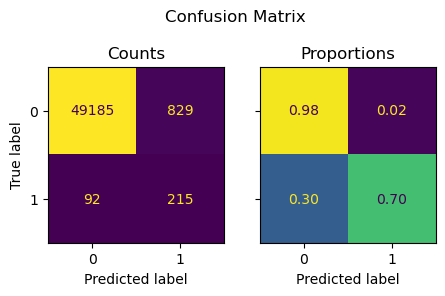

In [56]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=ax[0], colorbar=False)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_test,
    normalize="true",
    values_format=".2f",
    ax=ax[1],
    im_kw={"vmin": 0, "vmax": 1},
    colorbar=False,
)
fig.suptitle("Confusion Matrix")
ax[0].set_title("Counts")
ax[1].set_title("Proportions")
ax[1].set_ylabel(None)
fig.savefig(f"../figures/optimised.catBoost.cm.png")

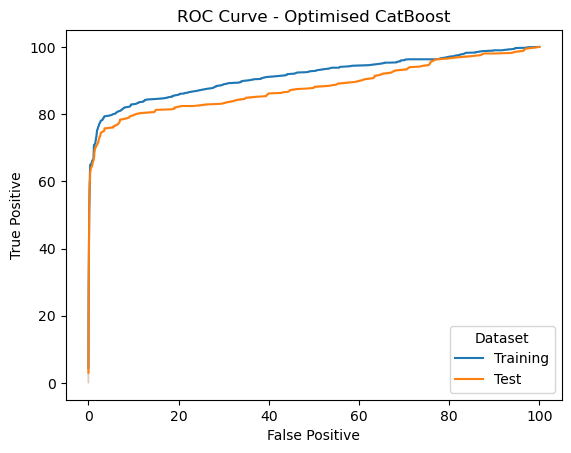

In [57]:
def make_roc_df(name, predictions, labels):
    fp, tp, _ = roc_curve(labels, predictions)
    return pd.DataFrame(
        {"False Positive": fp * 100, "True Positive": tp * 100, "Dataset": name}
    )


roc_df = pd.concat(
    [
        make_roc_df("Training", y_proba_train[:, -1], y_train),
        make_roc_df("Test", y_proba_test[:, -1], y_test),
    ]
)

sns.lineplot(roc_df, x="False Positive", y="True Positive", hue="Dataset")
plt.title("ROC Curve - Optimised CatBoost")
plt.show()